In [1]:
"""IMPORT EVERYTHING.. """
# Data manipulation
import pandas as pd
import numpy as np

# Quantitative analysis / indicators
import talib
import backtrader as bt

# # Machine learning / statistics
# import scipy
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import LinearRegression

# # Visualization
# import matplotlib.pyplot as plt
# import seaborn as sns
import mplfinance as mpf

# # Jupyter Notebook magic for inline plots
# %matplotlib inline


In [2]:
df = pd.read_parquet("../Src/filtered.XAUUSD-M1.parquet", engine="pyarrow")

# print(df.head(3))

In [3]:
from tafm import EnhancedTechnicalAnalyzer, create_analyzer, IndicatorConfig

df.rename(columns={
    'OPEN': 'Open',
    'HIGH': 'High',
    'LOW': 'Low',
    'CLOSE': 'Close',
    'VOL': 'Volume'
}, inplace=True)

def example_basic_indicators(df):
    """Example: Adding technical indicators"""

    # Initialize analyzer
    analyzer = create_analyzer(df)

    # Add indicators using fluent interface
    analyzer.add_indicator(
        IndicatorConfig(name='EMA', period=21)
    ).add_indicator(
        IndicatorConfig(name='EMA', period=50)
    ).add_indicator(
        IndicatorConfig(name='RSI', period=14)
    ).add_indicator(
        IndicatorConfig(name='MACD', fast_period=12, slow_period=26, signal_period=9)
    )

    analyzer.crossed_down('EMA_21', 'EMA_50', 'Cross_e2150')

    # View results
    print("DataFrame with indicators:")
    print(analyzer.df[['Close', 'EMA_21', 'EMA_50', 'RSI_14', 'MACD']].tail())

    # Get summary
    print("\nOperations Summary:")
    print(analyzer.summary())

    return analyzer

signal = example_basic_indicators(df)

2025-10-11 08:08:54,739 - INFO - Loaded 161 TALib indicators
2025-10-11 08:08:54,799 - INFO - OHLCV validation: {'Open': True, 'High': True, 'Low': True, 'Close': True, 'Volume': True}
2025-10-11 08:08:54,884 - INFO - Initialized analyzer - Shape: (351641, 5), Memory: 14.08MB
2025-10-11 08:08:55,186 - INFO - [OK] Added indicator EMA_21 in 0.2960s
2025-10-11 08:08:55,437 - INFO - [OK] Added indicator EMA_50 in 0.2652s
2025-10-11 08:08:55,750 - INFO - [OK] Added indicator RSI_14 in 0.3040s
2025-10-11 08:08:56,031 - INFO - [OK] Added indicator MACD in 0.2725s
2025-10-11 08:08:56,044 - INFO - [ OK ] EMA_21 crossed_down EMA_50 -> Cross_e2150 (0.0108s)


DataFrame with indicators:
                        Close       EMA_21       EMA_50     RSI_14      MACD
DATETIME                                                                    
2024-12-31 21:53:00  2624.517  2624.319708  2624.090799  60.272985  0.113984
2024-12-31 21:54:00  2624.468  2624.333189  2624.105591  57.936532  0.111753
2024-12-31 21:55:00  2624.438  2624.342718  2624.118626  56.492635  0.106339
2024-12-31 21:56:00  2624.475  2624.354743  2624.132602  57.886653  0.103836
2024-12-31 21:57:00  2624.381  2624.357130  2624.142343  53.221128  0.093194

Operations Summary:
                    Operation       Column  Success  Execution_Time_ms  \
0           ADD_INDICATOR_EMA       EMA_21     True             296.03   
1           ADD_INDICATOR_EMA       EMA_50     True             265.17   
2           ADD_INDICATOR_RSI       RSI_14     True             303.97   
3          ADD_INDICATOR_MACD         MACD     True             272.49   
4  EMA_21 crossed_down EMA_50  Cross_e2150 

In [4]:
from resampler import OHLCVResampler

# Resample to 1 hour - all columns preserved
resampler = OHLCVResampler(default_agg='last')

result = resampler.resample(signal.df, '1min', '2024-11-01', '2024-11-02')

result.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)

print(f"\nResampled shape: {result.shape}")

# result


Resampled shape: (1258, 10)


In [5]:
from stock_indicators import Quote, indicators

# Convert DataFrame to a list of Quote objects
quotes = [
    Quote(
        date,
        row.open,
        row.high,
        row.low,
        row.close,
        row.volume
    )
    for date, row in result.iterrows()
]

In [6]:
fractal_results = indicators.get_fractal(quotes, 15)

result['fractal_bear']= [r.fractal_bear for r in fractal_results]
result['fractal_bull']= [r.fractal_bull for r in fractal_results]

In [7]:
result.head(3)

,open,high,low,close,volume,EMA_21,EMA_50,RSI_14,MACD,Cross_e2150,fractal_bear,fractal_bull
DATETIME,,,,,,,,,,,,
2024-11-01 00:00:00,2746.672,2747.097,2745.759,2746.206,107,2746.694551,2746.701344,40.872200,-0.153766,1,None,None
2024-11-01 00:01:00,2746.118,2746.494,2745.806,2746.494,80,2746.676319,2746.693213,46.280187,-0.148516,0,None,None
2024-11-01 00:02:00,2746.491,2746.642,2745.958,2746.164,75,2746.629745,2746.672460,41.586613,-0.169034,0,None,None


In [8]:

from ChartterX5 import Chartter

chartter = Chartter(config={
    'chart_type': 'candle',
    'style': 'charles',
    'volume': False
})

chartter._setup_tradingview_theme()

cnf = {
        'title': 'NONE',
        'style': chartter.tradingview_style,
        'volume': False,
        'show_nontrading': False,
        'datetime_format': '%Y-%m-%d',
        'xlabel': '',
        'ylabel': '',
        'xrotation': 0
    }
# result.head(3)

In [9]:
fractal_bear_plot = result['fractal_bear'].copy()
fractal_bear_plot[fractal_bear_plot.isna()] = np.nan

fractal_bull_plot = result['fractal_bull'].copy()
fractal_bull_plot[fractal_bull_plot.isna()] = np.nan


Cross_e2150 = result[result['Cross_e2150']==1].index

vline_series = result['Cross_e2150'].replace(0, np.nan)

2025-10-11 08:09:01,064 - INFO - Generating chart 7e422794-0686-4cbb-bb28-4897e4d7d4bd with 1258 data points
2025-10-11 08:09:01,523 - INFO - Chart 7e422794-0686-4cbb-bb28-4897e4d7d4bd generated successfully in 0.46s


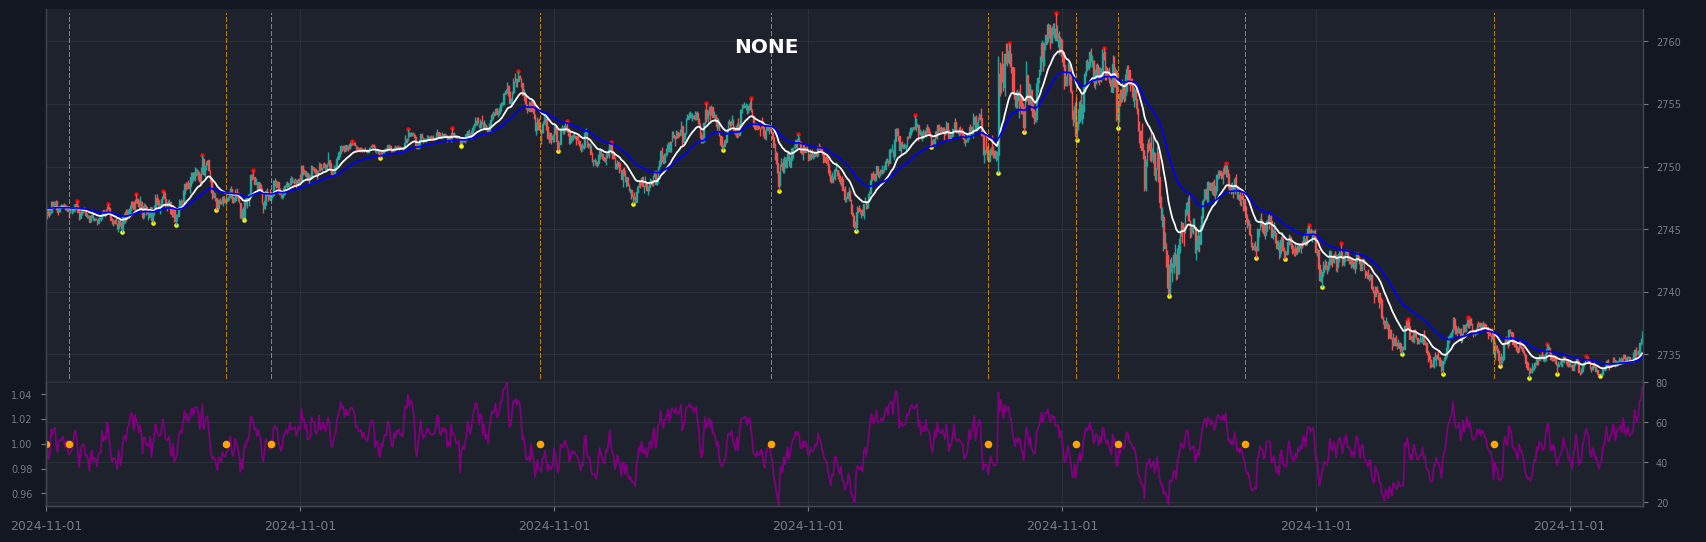

In [10]:
# Create base chart
fig, axes =chartter.plot(
    result,
    addplot=[
        mpf.make_addplot(result['RSI_14'], panel=1, color='purple', ylabel='RSI'),
        mpf.make_addplot(result['EMA_21'], panel=0, color='white', ylabel='RSI'),
        mpf.make_addplot(result['EMA_50'], panel=0, color='blue', ylabel='RSI'),
        mpf.make_addplot(fractal_bear_plot, panel=0, type='scatter', markersize=21, marker='.', color='red'),
        mpf.make_addplot(fractal_bull_plot, panel=0, type='scatter', markersize=21, marker='.', color='Yellow'),
        mpf.make_addplot(vline_series,panel=1,type='scatter',markersize=20,color='orange')
    ],
    config=cnf,
    vlines = {
        'vlines': Cross_e2150.to_list(),
        'colors': 'orange',
        'linewidths': 0.9,
        'linestyle': '--',
        'alpha': 0.7
    },
    returnfig=True
)

In [11]:
result['last_fractal'] = result['fractal_bear']

# Forward-fill to carry the last fractal value forward
result['last_fractal_ffill'] = result['last_fractal'].ffill()

result['entry'] = np.nan
result['sl'] = np.nan


# When Cross_e2150 == 1, assign the close as entry
result.loc[result['Cross_e2150'] == 1, 'entry'] = result['close']
result.loc[result['Cross_e2150'] == 1, 'sl'] = result['last_fractal_ffill']

result['risk'] = result['sl'].astype('float') - result['entry']

result['target'] = result['entry'] - result['risk'] * 1


result.loc[result['Cross_e2150'] == 1].head().T

DATETIME,2024-11-01 00:00:00,2024-11-01 00:18:00,2024-11-01 02:22:00,2024-11-01 02:57:00,2024-11-01 06:29:00
open,2746.672,2746.445,2747.255,2747.364,2753.043
high,2747.097,2746.448,2747.63,2747.804,2753.334
low,2745.759,2745.862,2746.909,2747.335,2752.81
close,2746.206,2746.359,2747.437,2747.66,2752.915
volume,107,78,86,94,126
EMA_21,2746.694551,2746.691453,2747.866045,2747.803419,2754.450284
EMA_50,2746.701344,2746.704089,2747.886415,2747.805751,2754.452348
RSI_14,40.8722,44.045493,44.946731,48.668396,36.068314
MACD,-0.153766,-0.047466,-0.369449,-0.054135,-0.557618
Cross_e2150,1,1,1,1,1


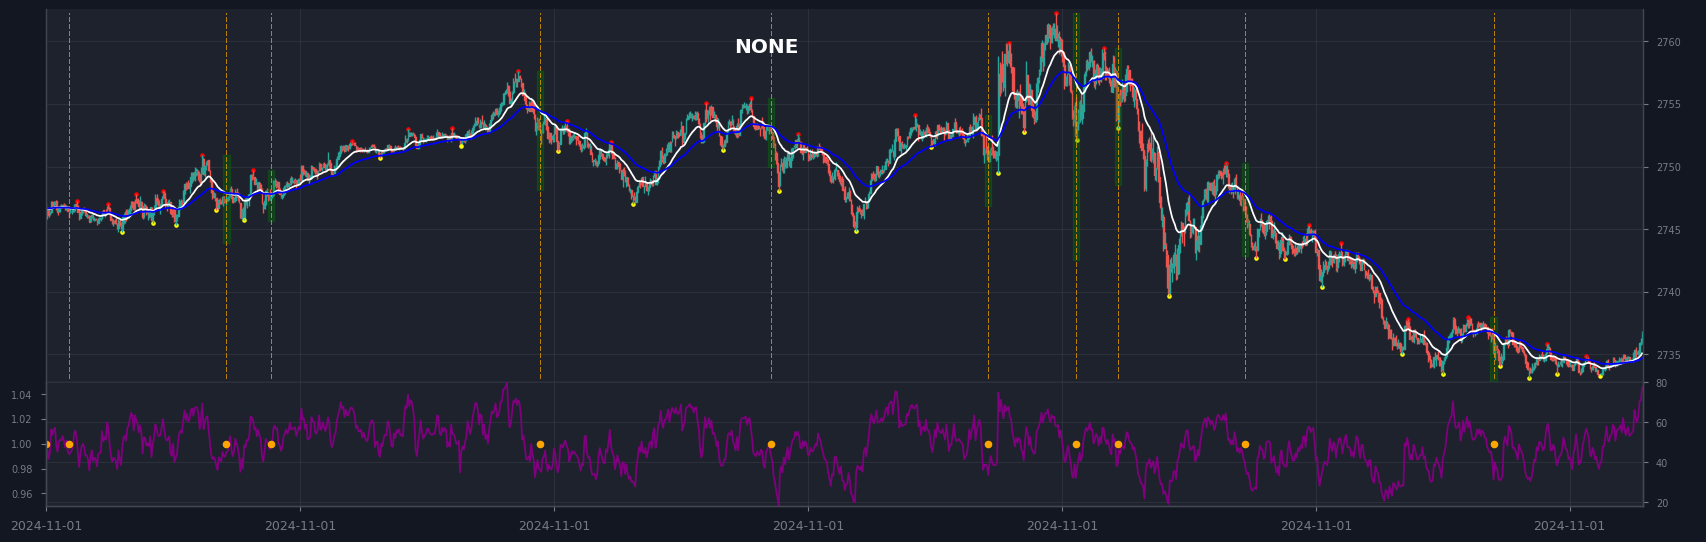

In [12]:
import mplfinance as mpf
import matplotlib.patches as patches

# Ensure numeric (float) types
result[['entry', 'sl', 'target']] = result[['entry', 'sl', 'target']].astype(float)

# Keep only valid rows
entries = result.dropna(subset=['entry', 'sl', 'target'])

ax = axes[0]

# Draw rectangles for each entry
for dt, row in entries.iterrows():
    x = result.index.get_loc(dt)
    width = 5
    height = row['target'] - row['sl']
    rect = patches.Rectangle(
        (x - width/2, row['sl']),
        width,
        height,
        linewidth=1,
        edgecolor='green',
        facecolor='green',
        alpha=0.3
    )
    ax.add_patch(rect)

fig


In [13]:
import numpy as np

# Select the relevant columns
dta = result[['open', 'high', 'low', 'close', 'volume','entry', 'sl', 'target']].copy()

dta.head(3)


,open,high,low,close,volume,entry,sl,target
DATETIME,,,,,,,,
2024-11-01 00:00:00,2746.672,2747.097,2745.759,2746.206,107,2746.206,NaN,NaN
2024-11-01 00:01:00,2746.118,2746.494,2745.806,2746.494,80,NaN,NaN,NaN
2024-11-01 00:02:00,2746.491,2746.642,2745.958,2746.164,75,NaN,NaN,NaN


In [14]:
from bktst import SignalDetector,TradeConfig,EnterpriseTradingFramework
# ============================================================================
# USAGE EXAMPLE
# ============================================================================

if __name__ == "__main__":
    # Load data and auto-detect signals
    # Expected columns: open, high, low, close, volume, entry, sl, target
    # signal column will be created automatically

    # Auto-detect signals from entry/sl relationship
    df = SignalDetector.detect_signals(dta)

    print("Signal Detection Summary:")
    print(df[['entry', 'sl', 'target', 'signal']].head(10))
    print(f"\nBUY signals detected: {(df['signal']==1).sum()}")
    print(f"SELL signals detected: {(df['signal']==2).sum()}\n")

    # Create configuration
    config = TradeConfig(
        risk_pct=0.02,
        max_positions=5,
        max_daily_loss=0.05,
        cash=100000.0,
        commission=0.001
    )

    # Run backtest
    framework = EnterpriseTradingFramework()
    results = framework.run_backtest(df, config)

    # Display results
    print("\n" + "="*80)
    print("ACCOUNT SUMMARY")
    print("="*80)
    print(results['account_summary'].to_string(index=False))

    print("\n" + "="*80)
    print("TRADE JOURNAL")
    print("="*80)
    if len(results['trades_table']) > 0:
        print(results['trades_table'].to_string(index=False))
        trades = results['trades_table']
        print(f"\nAvg Win: ${trades[trades['outcome']=='WIN']['pnl'].mean():.2f}")
        print(f"Avg Loss: ${trades[trades['outcome']=='LOSS']['pnl'].mean():.2f}")
    else:
        print("No trades executed")

    print("\n" + "="*80)
    print("DAILY SUMMARY")
    print("="*80)
    if len(results['daily_summary']) > 0:
        print(results['daily_summary'].to_string(index=False))

    # Export
    results['account_summary'].to_csv('account_summary.csv', index=False)
    if len(results['trades_table']) > 0:
        results['trades_table'].to_csv('trades_journal.csv', index=False)
    if len(results['daily_summary']) > 0:
        results['daily_summary'].to_csv('daily_summary.csv', index=False)

    print("\n✓ Results exported to CSV files")

2025-10-11 08:09:04,268 - INFO - Enterprise Trading Framework initialized
2025-10-11 08:09:04,270 - INFO - Starting backtest | Capital: $100,000 | Risk/Trade: 2.0%


Signal Detection Summary:
                        entry  sl  target  signal
DATETIME                                         
2024-11-01 00:00:00  2746.206 NaN     NaN       0
2024-11-01 00:01:00       NaN NaN     NaN       0
2024-11-01 00:02:00       NaN NaN     NaN       0
2024-11-01 00:03:00       NaN NaN     NaN       0
2024-11-01 00:04:00       NaN NaN     NaN       0
2024-11-01 00:05:00       NaN NaN     NaN       0
2024-11-01 00:06:00       NaN NaN     NaN       0
2024-11-01 00:07:00       NaN NaN     NaN       0
2024-11-01 00:08:00       NaN NaN     NaN       0
2024-11-01 00:09:00       NaN NaN     NaN       0

BUY signals detected: 0
SELL signals detected: 9



2025-10-11 08:09:05,015 - INFO - Initializing Enterprise Strategy
2025-10-11 08:09:05,031 - INFO - Strategy initialized | Capital: $100,000.00
2025-10-11 08:09:05,089 - INFO - SELL Order | Entry: $2747.44 | SL: $2750.96 | TP: $2743.92 | Size: 3
2025-10-11 08:09:05,094 - INFO - Order executed | SELL -3 @ $2747.44
2025-10-11 08:09:05,109 - INFO - Order executed | BUY 3 @ $2750.96
2025-10-11 08:09:05,110 - INFO - Trade #1 closed | SELL | LOSS | P&L: $-10.56
2025-10-11 08:09:05,140 - INFO - SELL Order | Entry: $2752.91 | SL: $2757.66 | TP: $2748.17 | Size: 3
2025-10-11 08:09:05,144 - INFO - Order executed | SELL -3 @ $2752.91
2025-10-11 08:09:05,152 - INFO - Order executed | BUY 3 @ $2748.17
2025-10-11 08:09:05,152 - INFO - Trade #2 closed | SELL | WIN | P&L: $14.23
2025-10-11 08:09:05,190 - INFO - SELL Order | Entry: $2752.72 | SL: $2755.48 | TP: $2749.96 | Size: 3
2025-10-11 08:09:05,193 - INFO - Order executed | SELL -3 @ $2752.74
2025-10-11 08:09:05,195 - INFO - Order executed | BUY 3 


ACCOUNT SUMMARY
 starting_capital  ending_capital  total_pnl  total_return_pct  max_drawdown_pct  buy_signals  sell_signals  total_signals  trades_executed  total_orders  winning_trades  losing_trades  win_rate_pct  signal_conversion_pct
         100000.0    99929.775214 -70.224786         -0.070225          0.093388            0             9              9                7            61               4              3     57.142857              77.777778

TRADE JOURNAL
 trade_id signal_type      entry_datetime       exit_datetime  entry_price  exit_price exit_type  size     pnl  return_pct outcome  sl_level  tp_level  risk_amount  reward_amount  rr_ratio  account_balance  commission
        1        SELL 2024-11-01 02:22:00 2024-11-01 03:42:00     2747.437    2750.956        SL     3 -10.557   -0.128083    LOSS  2750.956  2743.918       10.557         10.557  1.000000     99972.947821         0.0
        2        SELL 2024-11-01 06:29:00 2024-11-01 07:39:00     2752.915    2748.170  